In [2]:
import os
import pandas as pd

import seaborn as sns
from seaborn import plt
sns.set_style('white')

%matplotlib inline

### Load data

Option A

In [24]:
authors = pd.read_csv('../data/processed/authors.csv')
books = pd.read_csv('../data/processed/books.csv')
nyt = pd.read_csv('../data/processed/nyt.csv')

Option B

In [22]:
def get_processed_data(csv_name):
    '''Returns df of csv in processed data directory'''
    path = os.path.join(os.pardir, 'data', 'processed', csv_name)
    return pd.read_csv(path)

In [50]:
authors = get_processed_data('authors.csv')
books = get_processed_data('books.csv')

### Authors EDA

In [51]:
authors.columns

Index([u'a_id', u'a_fans_count', u'a_works_count', u'gender', u'hometown',
       u'a_avg_rating', u'a_ratings_count', u'a_text_reviews_count', u'author',
       u'a_wks_on_list', u'a_books_on_list'],
      dtype='object')

In [52]:
books.columns

Index([u'b_id', u'gr_title', u'nyt_title', u'b_count', u'pub_yr',
       u'b_avg_rating', u'b_ratings_count', u'b_txt_rev_count', u'publisher',
       u'b_rating_5_count', u'b_rating_4_count', u'b_rating_3_count',
       u'b_rating_2_count', u'b_rating_1_count', u'b_wks_on_list', u'decade',
       u'a_id'],
      dtype='object')

Top 10 authors with highest number of weeks on the NYT list (could be multiple books)

In [5]:
authors.sort_values('a_wks_on_list', ascending=False)[['author', 'a_wks_on_list']].head(10)

,author,a_wks_on_list
67,James A. Michener,200.0
126,Stephen King,144.0
128,John Grisham,139.0
92,James Patterson,102.0
226,Danielle Steel,94.0
236,Herman Wouk,91.0
153,Robert Ludlum,81.0
238,John le Carré,77.0
101,Dan Brown,75.0
127,Tom Clancy,74.0


Bar plot of weeks spent on list by gender (85% of authors reporting gender)

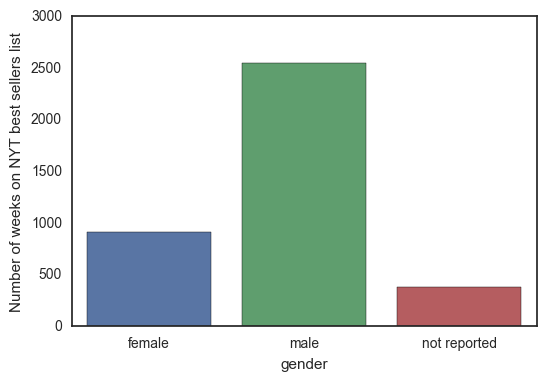

In [6]:
wks_by_gender = authors.groupby('gender', as_index=False).sum()[['gender', 'a_wks_on_list']]
fig1 = sns.barplot(x='gender', y='a_wks_on_list', data=wks_by_gender)
fig1.set(ylabel='Number of weeks on NYT best sellers list');

Bar plot of authors by gender

In [48]:
def create_empty_fig(xlabel='', ylabel=''):
    '''Returns empty Tufte-style fig, ax objects'''
    # create figures and axes objects to modify
    fig, ax = plt.subplots(figsize=(8,6))

    # remove y axis tick labels
    ax.set_yticklabels([])

    # remove square outline
    ax.set_frame_on(False)
    
    # add labels for axes
    ax.set(xlabel=xlabel, ylabel=ylabel);
    
    return fig, ax

In [53]:
def highlight_max(data, highlight, standard):
    '''Sets biggest value to highlight color'''
    return [standard if (x < max(data.values)) else highlight for x in data.values]

In [77]:
def add_bar_labels(data, ax):
    '''Adds labels to tops of bars of sns barplot'''
    labels = data.values # label each bar with y value
    y_margin = max(labels) * 0.01
    for bar, label in zip(ax.patches, labels):
        #x location of label
        x = bar.get_x()
        bar_width = bar.get_width()
        center = x + bar_width/2.0

        #y location of label
        bar_height = bar.get_height()

        ax.text(x=center, y=bar_height + y_margin, s=label, ha='center')

In [78]:
def highlighted_bar_chart(data, xlabel='', ylabel=''):
    # create empty fig, ax
    fig, ax = create_empty_fig(xlabel='Gender', ylabel='Number of authors')

    # draw plot bar
    # color palette
    highlight = '#4c4e2f'
    standard = '#a4a86f'

    colors = highlight_max(data, highlight, standard)
    sns.barplot(x=data.index, y=data.values, palette=colors)

    # add labels on top of bars
    add_bar_labels(data, ax)

male            129
female           78
not reported     34
Name: gender, dtype: int64


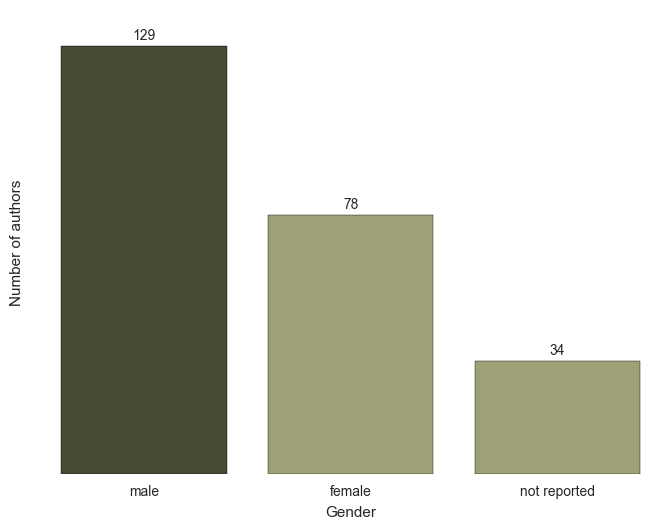

In [60]:
# create empty fig, ax
fig, ax = create_empty_fig(xlabel='Gender', ylabel='Number of authors')

# dataset is number of authors by gender
data = authors['gender'].value_counts()
print(data)

# draw plot bar
# color palette
highlight = '#4c4e2f'
standard = '#a4a86f'

colors = highlight_max(data, highlight, standard)
sns.barplot(x=data.index, y=data.values, palette=colors)

# add labels on top of bars
add_bar_labels(data, ax)

gender
female           910.0
male            2553.0
not reported     379.0
Name: a_wks_on_list, dtype: float64


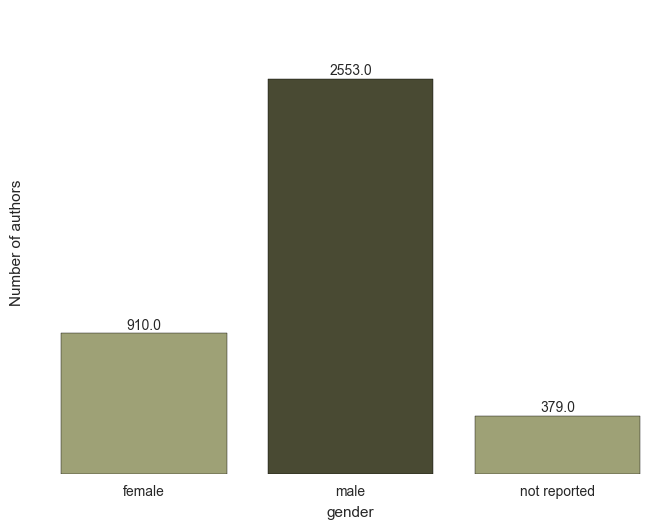

In [79]:
# dataset is number of authors by gender
wks_by_gender = authors.groupby('gender').sum()['a_wks_on_list']
print(wks_by_gender)

highlighted_bar_chart(wks_by_gender, xlabel='Gender', ylabel='Number of weeks on list')

male            129
female           78
not reported     34
Name: gender, dtype: int64


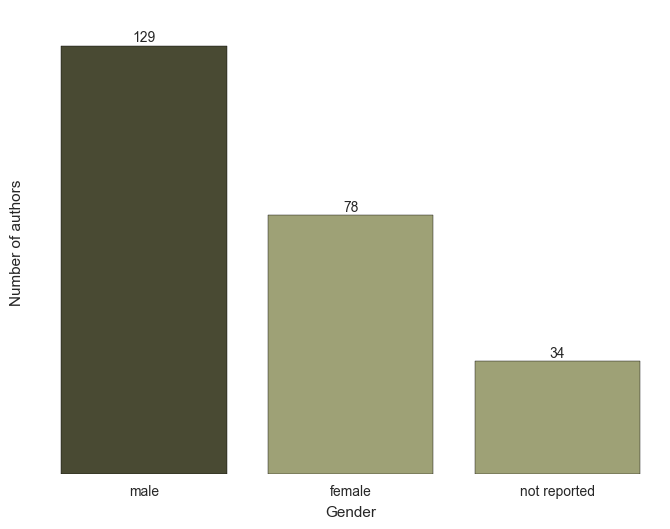

In [80]:
# dataset is number of authors by gender
data = authors['gender'].value_counts()
print(data)

highlighted_bar_chart(data, xlabel='Gender', ylabel='Number of authors')

Histogram of numbers of weeks spent on list by author

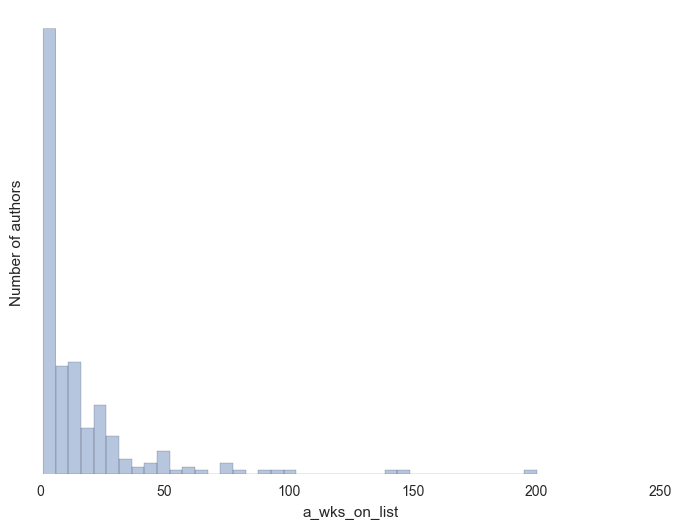

In [59]:
# create empty fig, ax
fig, ax = create_empty_fig(xlabel='Number of weeks on NYT list', ylabel='Number of authors')
sns.distplot(authors['a_wks_on_list'], kde=False);

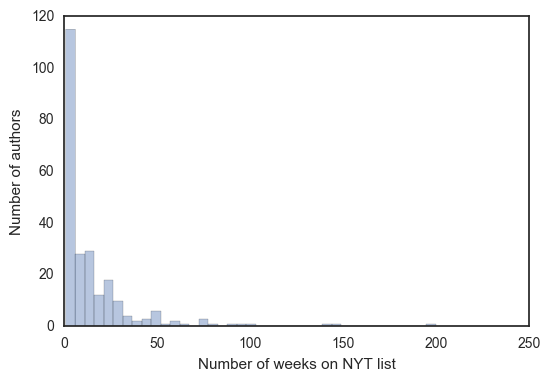

In [61]:
fig3 = sns.distplot(authors['a_wks_on_list'], kde=False)
fig3.set(xlabel='Number of weeks on NYT list', ylabel='Number of authors');

Histogram of number of books (total) by author.

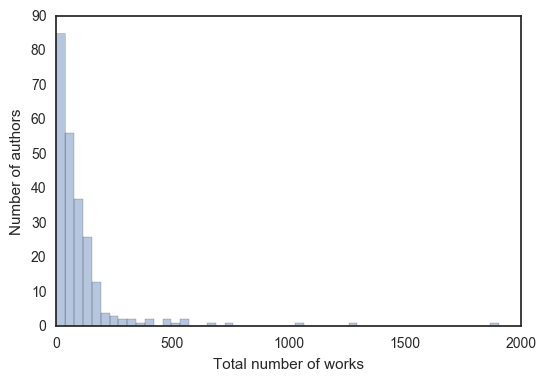

In [62]:
fig4 = sns.distplot(authors['a_works_count'], kde=False)
fig4.set(xlabel='Total number of works', ylabel='Number of authors');

Top 10 authors with highest number of total works

In [10]:
authors.sort_values('a_works_count', ascending=False)[['author','a_works_count', 'a_wks_on_list']].head(10)

,author,a_works_count,a_wks_on_list
164,Agatha Christie,1905,26.0
126,Stephen King,1260,144.0
124,Neil Gaiman,1062,1.0
132,George R.R. Martin,744,2.0
184,Nora Roberts,652,23.0
165,W. Somerset Maugham,560,4.0
6,Ernest Hemingway,543,7.0
92,James Patterson,498,102.0
24,Umberto Eco,483,5.0
15,Louis L'Amour,465,6.0


Histogram of number of books on NYT list by author.

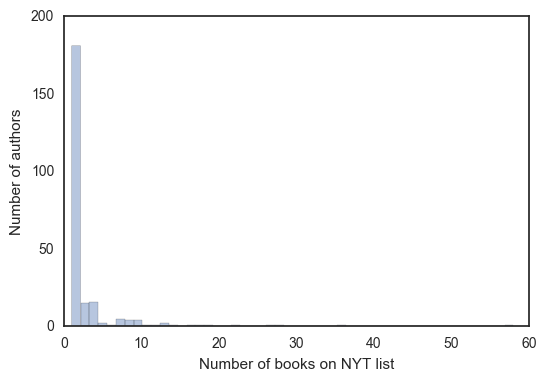

In [11]:
fig5 = sns.distplot(authors['a_books_on_list'], kde=False);
fig5.set(xlabel='Number of books on NYT list', ylabel='Number of authors');

Top 10 authors with highest number of books on NYT list

In [12]:
authors.sort_values('a_books_on_list', ascending=False)[['author','a_books_on_list', 'a_wks_on_list']].head(10)

,author,a_books_on_list,a_wks_on_list
92,James Patterson,58.0,102.0
126,Stephen King,36.0,144.0
226,Danielle Steel,28.0,94.0
128,John Grisham,27.0,139.0
97,Janet Evanovich,22.0,33.0
184,Nora Roberts,19.0,23.0
168,Patricia Cornwell,18.0,42.0
111,Mary Higgins Clark,16.0,44.0
127,Tom Clancy,14.0,74.0
43,David Baldacci,13.0,15.0


Histogram of average book rating

In [13]:
authors['a_avg_rating'].mean()

3.961825726141078

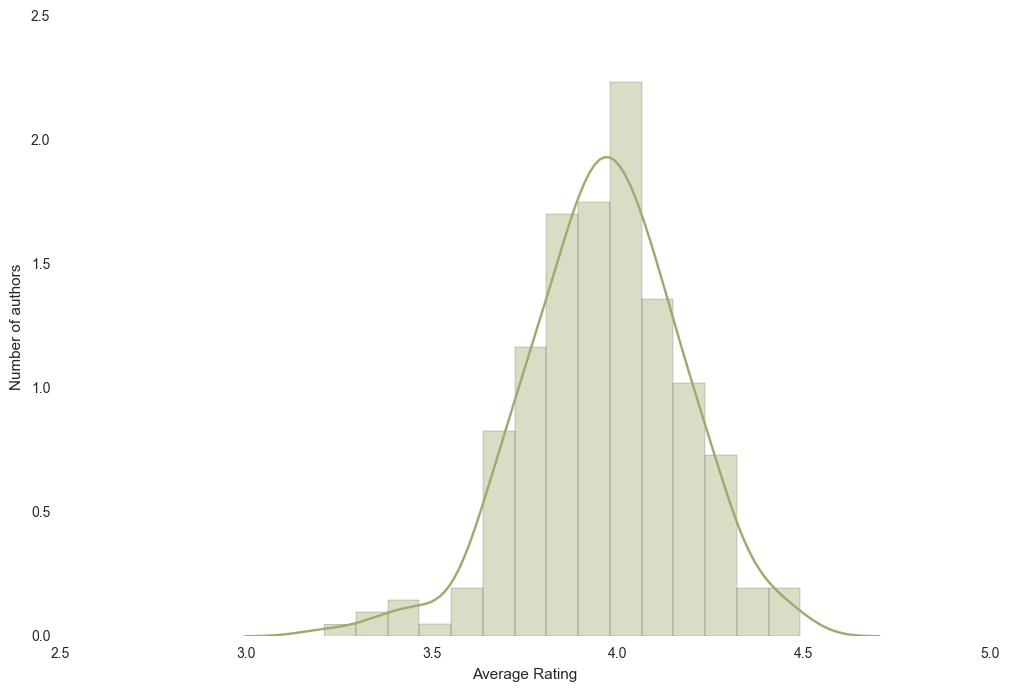

In [106]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_frame_on(False)
fig6 = sns.distplot(authors['a_avg_rating'], kde=True, color='#a4a86f');
fig6.set(xlabel='Average Rating', ylabel='Number of authors');

Author pairplots

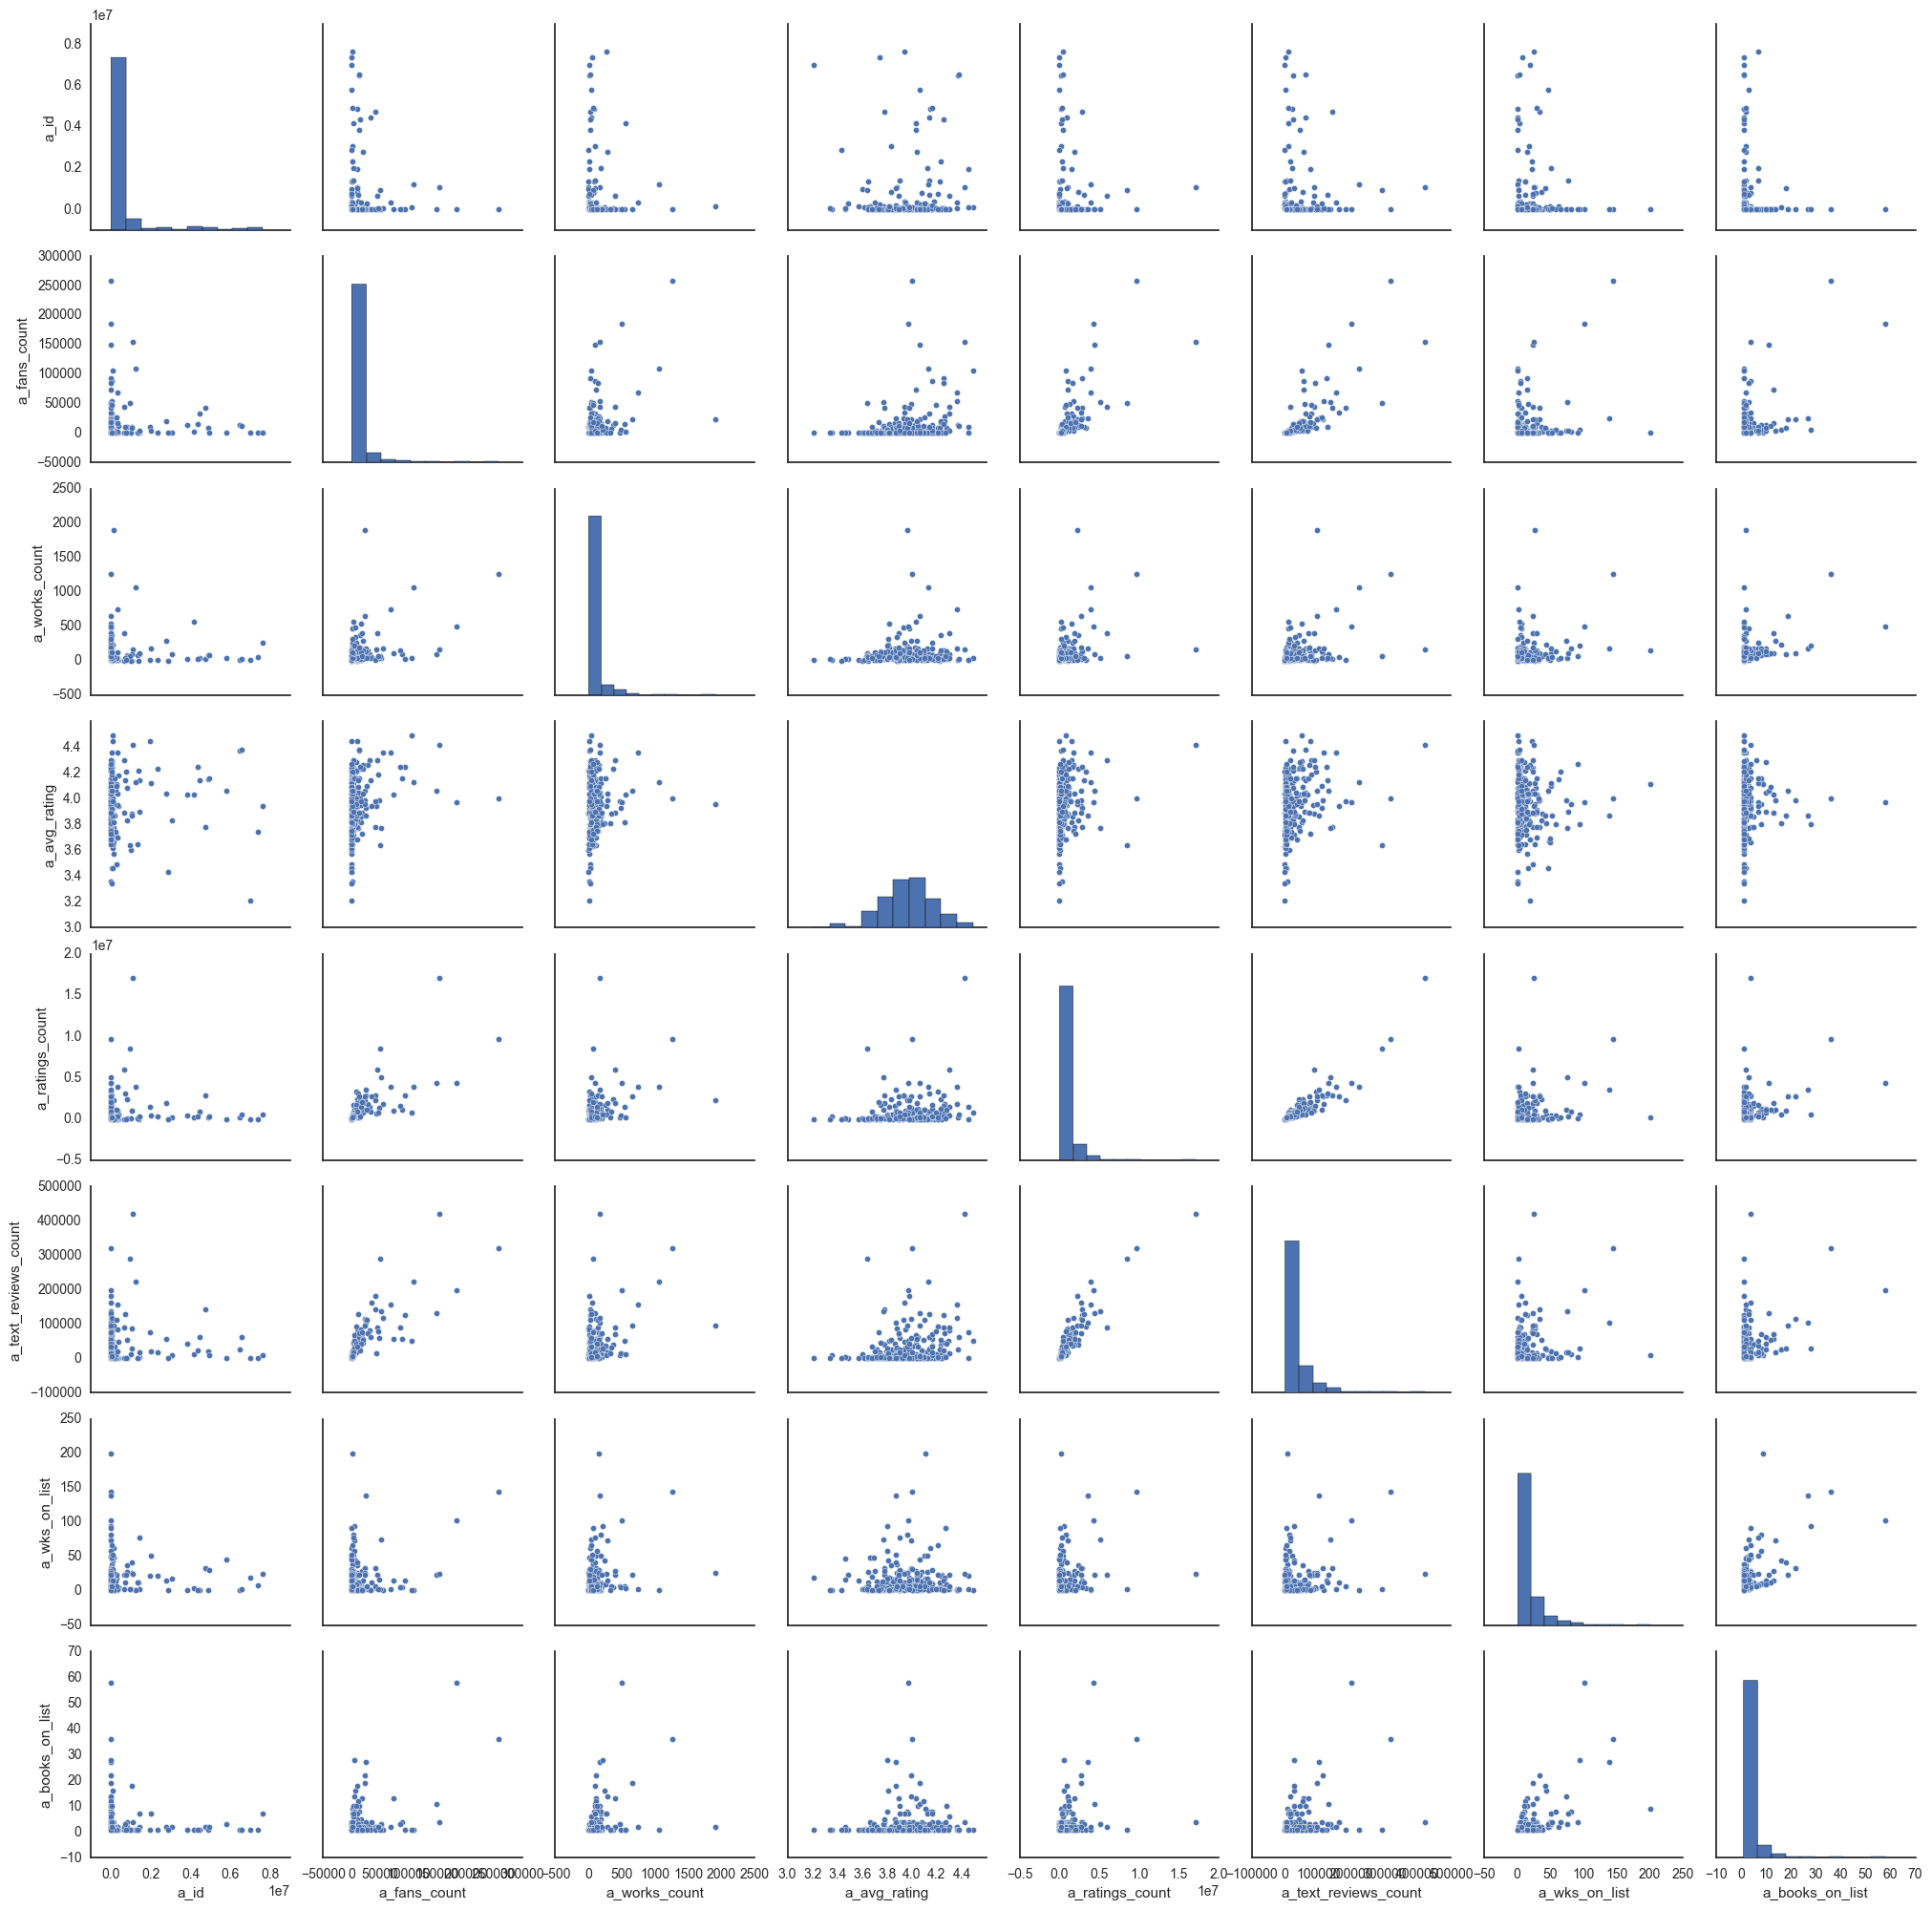

In [15]:
sns.pairplot(authors);

### Books EDA

In [16]:
#calculate number of weeks each book was on NYT lists by year, by book, and by author
nyt_by_year = nyt.groupby(by=['title', 'author', 'year'], as_index=False).count()[['title', 'author', 'year', 'date']]

In [17]:
#rename columns to be able to join nyt df with goodreads dfs
columns = {'title': 'nyt_title',
           'date': 'b_wks_on_list'}

nyt_by_year.rename(columns=columns, inplace=True)

Bar plot of total number of books per year

In [18]:
nyt_by_year = nyt_by_year.groupby('year', as_index=False).count()[['year', 'nyt_title']]

In [19]:
nyt_by_year.rename(columns={'nyt_title': 'num_of_books'}, inplace=True)

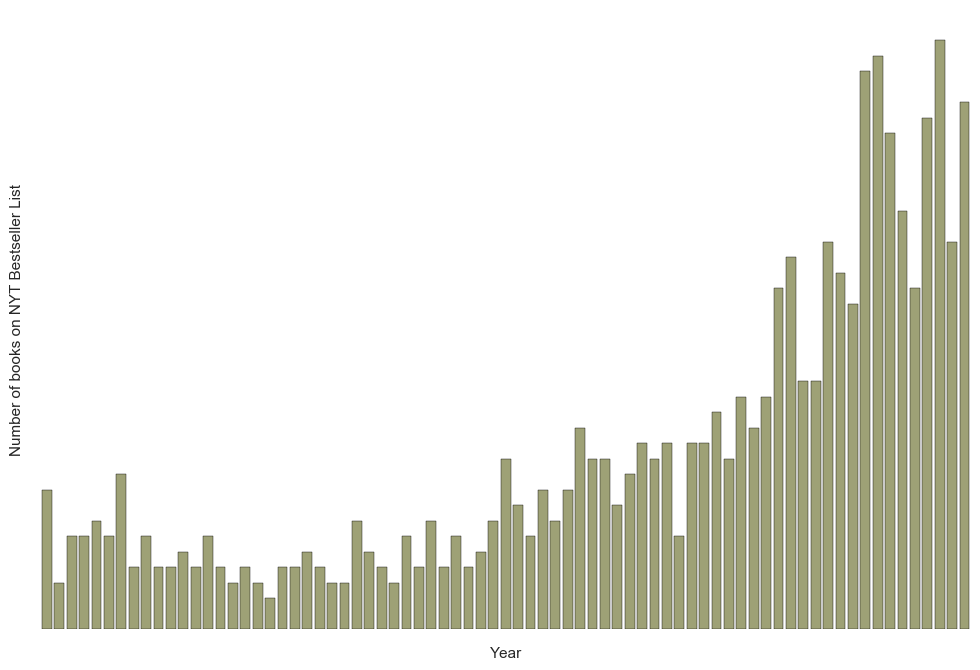

In [76]:
fig, ax = plt.subplots(figsize=(12,8))
fig7 = sns.barplot(x='year', y='num_of_books', data=nyt_by_year, ax=ax, color='#a4a86f')
fig7.set(ylabel='Number of books on NYT Bestseller List')
fig7.set(Xlabel='Year')
ax.set_frame_on(False)
fig7.set(yticklabels=[])
fig7.set(xticklabels=[]);

Bar plot of total books per decade

In [21]:
books_by_decade = books.groupby('decade', as_index=False).count()[['decade', 'nyt_title']]
books_by_decade.rename(columns={'nyt_title': 'num_of_books'}, inplace=True)

In [81]:
books_by_decade.loc[books_by_decade['decade']=='2010s', 'num_of_books'] = (194*10/7)

In [78]:
194*10/7

277

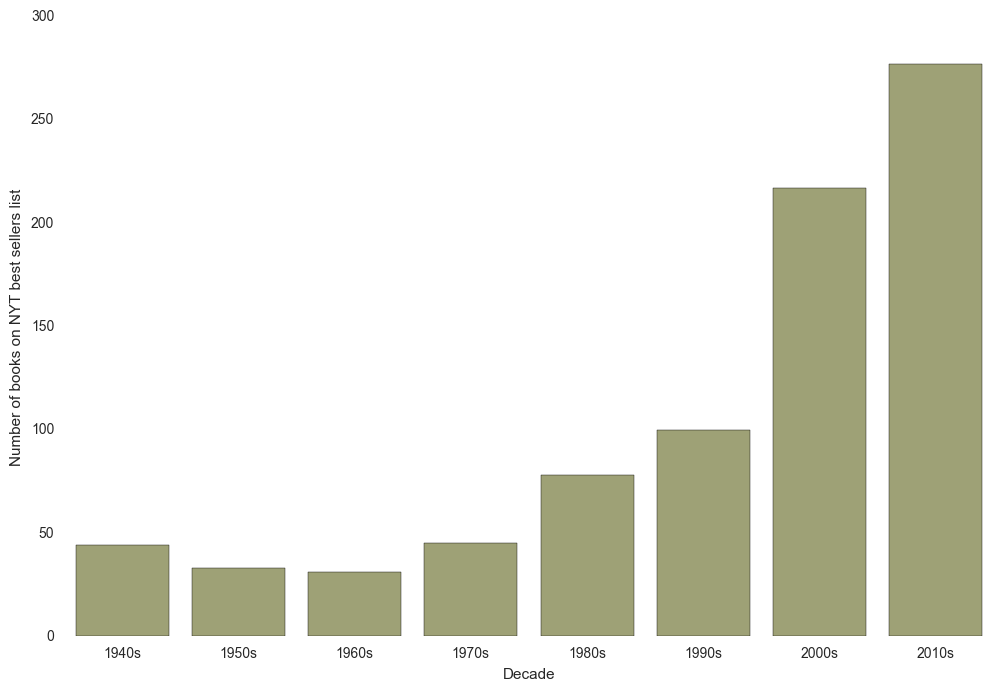

In [97]:
fig, ax = plt.subplots(figsize=(12,8))
fig8 = sns.barplot(x='decade', y='num_of_books', data=books_by_decade, ax=ax, color='#a4a86f')
fig8.set(ylabel='Number of books on NYT best sellers list')
fig8.set(xlabel='Decade')
ax.set_frame_on(False)
plt.xticks(rotation=0);

Bar plot of total books by publisher

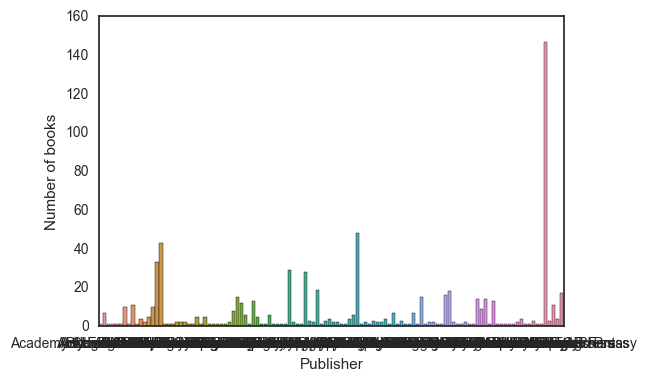

In [23]:
pub_counts = books.groupby('publisher', as_index=False).count()[['publisher', 'b_count']]
fig9 = sns.barplot(x='publisher', y='b_count', data=pub_counts)
fig9.set(xlabel='Publisher', ylabel='Number of books');

Bar plot of total books by publisher (without unknowns)

In [24]:
#remove Unknown
pub_counts = pub_counts.drop(111)

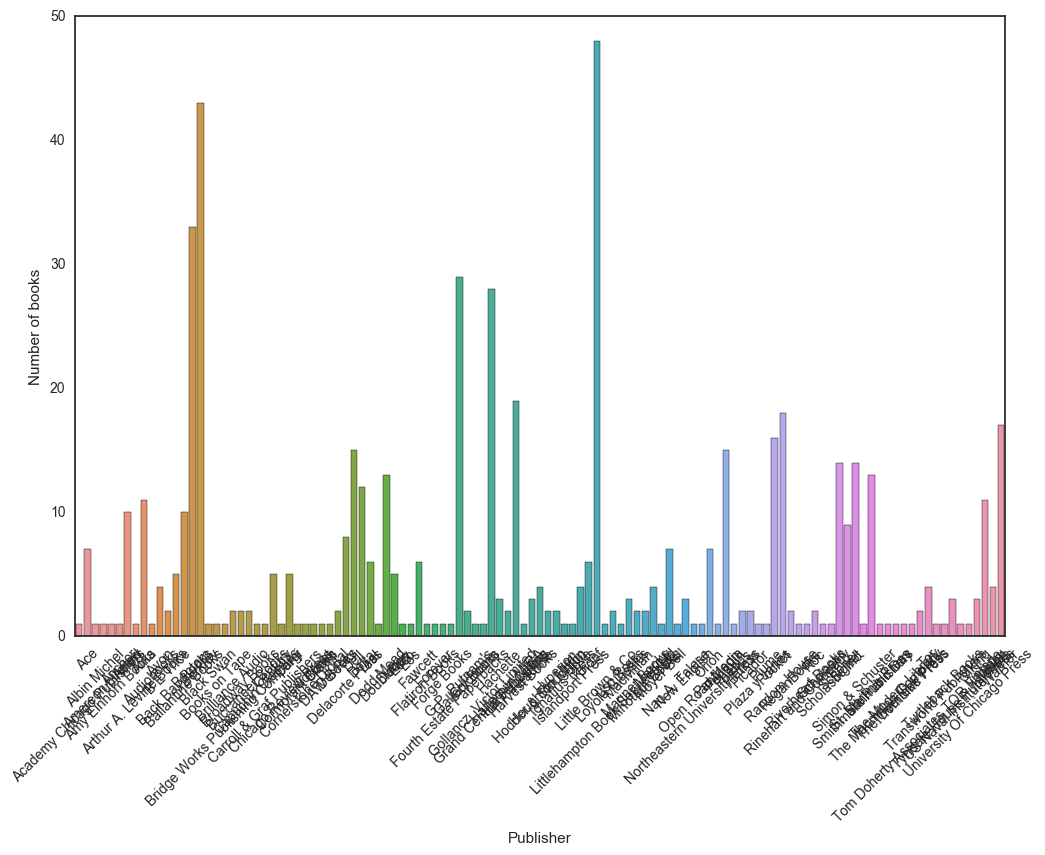

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
fig10 = sns.barplot(x='publisher', y='b_count', data=pub_counts, ax=ax)
fig10.set(xlabel='Publisher', ylabel='Number of books');
plt.xticks(rotation=45);

Bar plot of total books by publisher by decade (without unknowns)

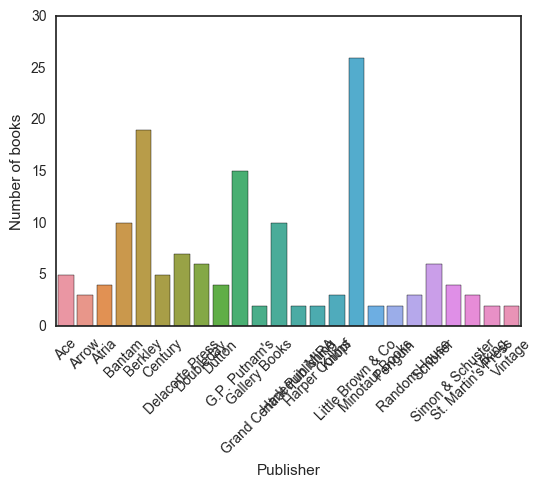

In [67]:
pub_counts_decades = books.groupby(['publisher', 'decade'], as_index=False).count()[['publisher', 'decade', 'b_count']]
decade = pub_counts_decades[pub_counts_decades['decade']=='2010s']
decade = decade[decade['b_count'] > 1]
decade = decade[decade['publisher'] != 'Unknown']
fig16 = sns.barplot(x='publisher', y='b_count', data=decade)
fig16.set(xlabel='Publisher', ylabel='Number of books')
plt.xticks(rotation=45);

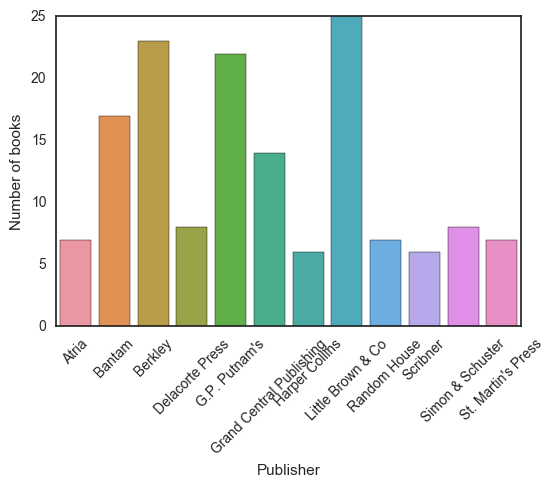

In [27]:
pub_counts = books.groupby(['publisher', 'b_wks_on_list'], as_index=False).count()[['publisher', 'b_wks_on_list', 'b_count']]
pub_counts = pub_counts[pub_counts['b_wks_on_list'] == 1]
pub_counts = pub_counts[pub_counts['b_count'] > 5]
pub_counts = pub_counts[pub_counts['publisher'] != 'Unknown']
fig9 = sns.barplot(x='publisher', y='b_count', data=pub_counts)
fig9.set(xlabel='Publisher', ylabel='Number of books')
plt.xticks(rotation=45);

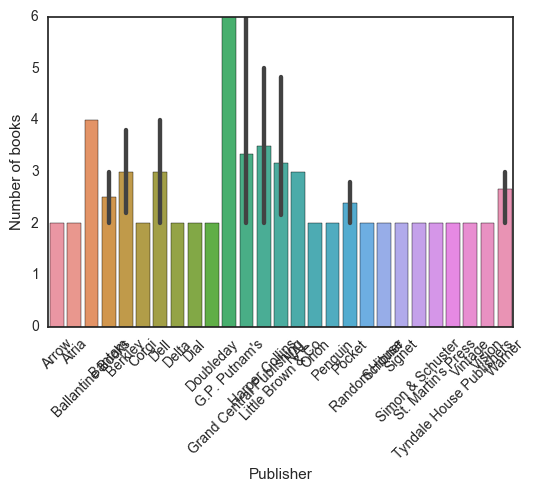

In [28]:
pub_counts = books.groupby(['publisher', 'b_wks_on_list'], as_index=False).count()[['publisher', 'b_wks_on_list', 'b_count']]
pub_counts = pub_counts[pub_counts['b_wks_on_list'] > 1]
pub_counts = pub_counts[pub_counts['b_count'] > 1]
pub_counts = pub_counts[pub_counts['publisher'] != 'Unknown']
fig9 = sns.barplot(x='publisher', y='b_count', data=pub_counts)
fig9.set(xlabel='Publisher', ylabel='Number of books')
plt.xticks(rotation=45);

Histogram of number of weeks on NYT list by book

In [123]:
len(books)

742

In [127]:
float(len(books[books['b_wks_on_list']<7]))/len(books)

0.7668463611859838

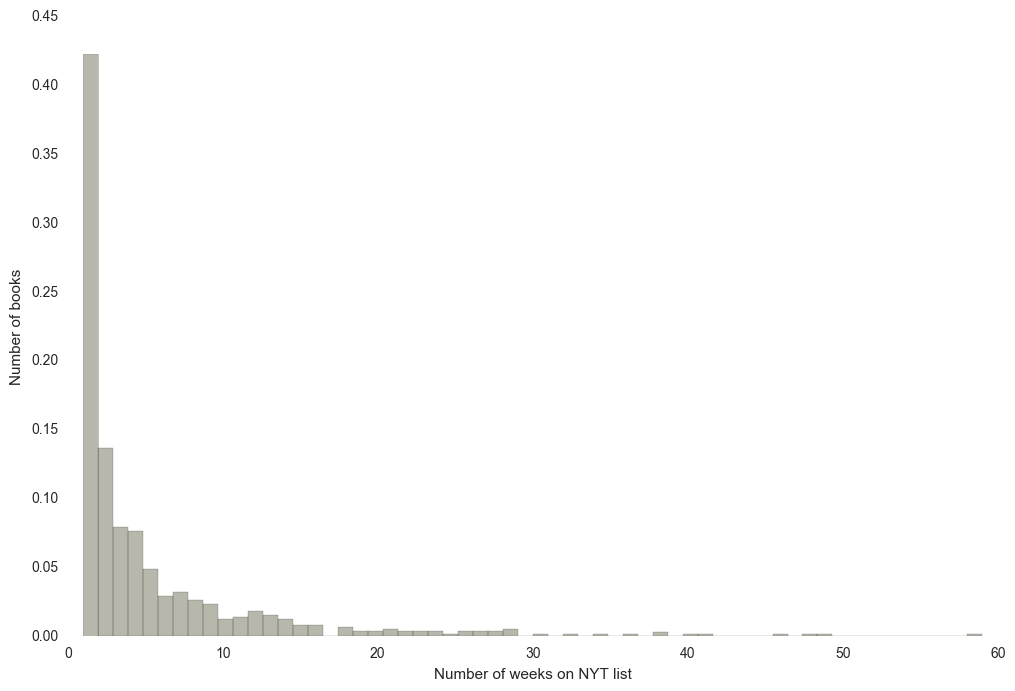

In [150]:
fig, ax = plt.subplots(figsize=(12,8))
#fig8 = sns.barplot(x='decade', y='num_of_books', data=books_by_decade, ax=ax, palette='RdBu')
#fig8.set(ylabel='Number of books on NYT best sellers list')
#fig8.set(xlabel='Decade')
ax.set_frame_on(False)
plt.xticks(rotation=0);

dark = '#4c4e2f'
light = '#a4a86f'

fig11 = sns.distplot(books['b_wks_on_list'], bins=60, kde=False, norm_hist=True, ax=ax, color=dark)
fig11.set(xlabel='Number of weeks on NYT list', ylabel='Number of books');

Top 10 books with longest run on NYT list

In [48]:
books.sort_values('b_wks_on_list', ascending=False)[['nyt_title', 'author', 'decade', 'b_wks_on_list']].head(10)

,nyt_title,author,decade,b_wks_on_list
325,The Da Vinci Code,Dan Brown,2000s,59
254,Hawaii,James A. Michener,1960s,49
496,The Caine Mutiny,Herman Wouk,1950s,48
661,The Robe,Lloyd C. Douglas,1940s,46
472,Love Story,Erich Segal,1970s,41
247,The Source,James A. Michener,1960s,40
678,The Bridges of Madison County,Robert James Waller,1990s,38
551,Jonathan Livingston Seagull,Richard Bach,1970s,38
391,Trinity,Leon Uris,1970s,36
84,The Spy Who Came in from the Cold,John le Carré,1960s,34


Histogram of average book rating

In [31]:
books['b_avg_rating'].mean()

3.943369272237198

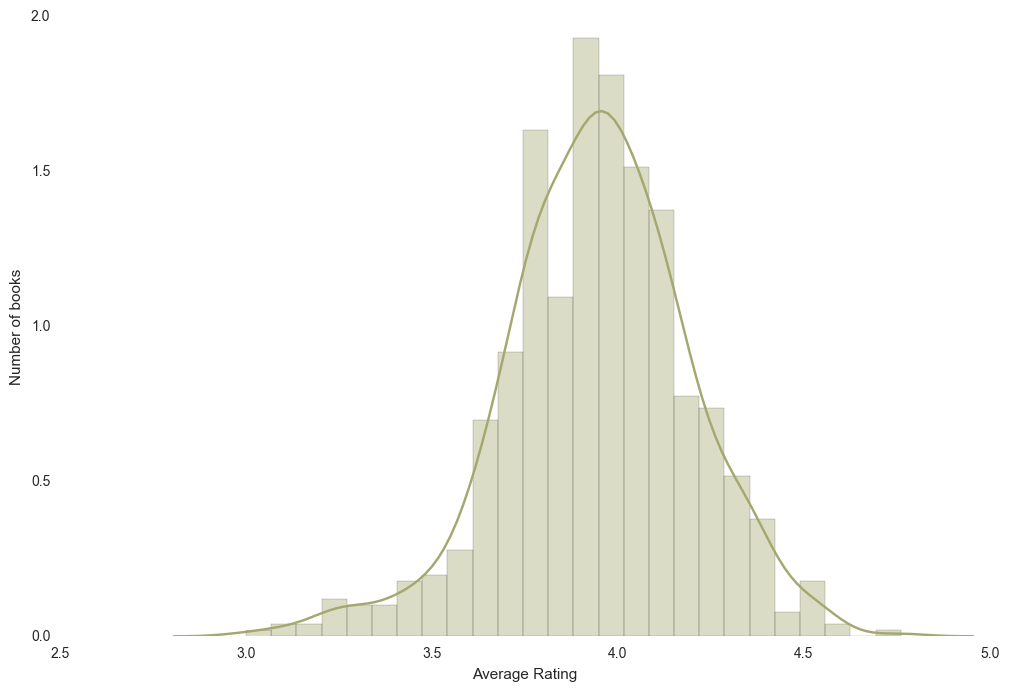

In [100]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_frame_on(False)
fig12 = sns.distplot(books['b_avg_rating'], kde=True, color='#a4a86f');
fig12.set(xlabel='Average Rating', ylabel='Number of books');

Top 10 highly rated books

In [33]:
books.sort_values('b_avg_rating', ascending=False).head(10)[['nyt_title', 'b_avg_rating']]

,nyt_title,b_avg_rating
589,Words of Radiance,4.76
507,Acheron,4.59
158,The Wise Man's Fear,4.57
161,Skin Game,4.55
159,Changes,4.54
337,The Nightingale,4.53
392,QB VII,4.53
574,Harry Potter and the Prisoner of Azkaban,4.52
376,A Great Reckoning,4.51
601,Morning Star,4.50


Scatter plot of average book rating vs. number of weeks on NYT list

In [84]:
more_than_one = books[books['b_wks_on_list']>1]

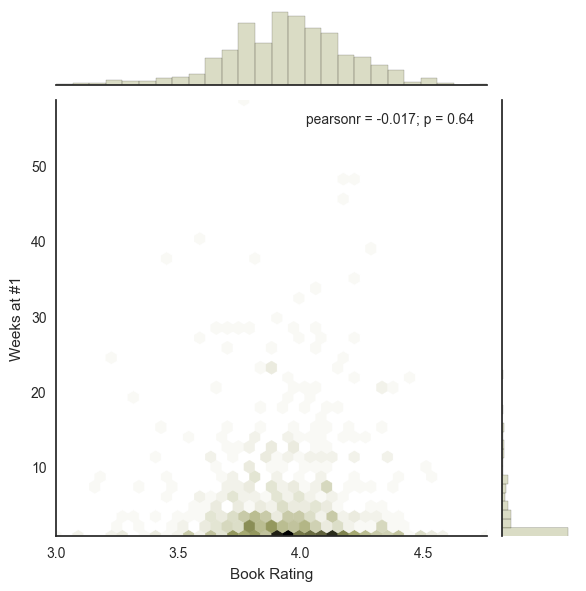

In [193]:
fig13 = sns.jointplot(x='b_avg_rating',
                      y='b_wks_on_list',
                      data=books,
                      kind='hex',
                      color='#a4a86f');
fig13.set_axis_labels(xlabel='Book Rating', ylabel='Weeks at #1');

Scatter plot of average book rating vs. number of weeks on NYT list; separate plot for each decade

In [35]:
decades = books['decade'].unique()

In [36]:
decades.sort()

In [37]:
books[books['decade']=='1940s'].sort_values('b_avg_rating')[['nyt_title', 'author', 'b_avg_rating', 'b_id', 'a_id']].head()

,nyt_title,author,b_avg_rating,b_id,a_id
607,The Hucksters,Frederic Wakeman,3.32,153033,6997290
587,Drivin' Woman,Elizabeth Pickett Chevalier,3.43,6307651,2865170
604,So Well Remembered,James Hilton,3.52,413616,2031
689,Mrs. Parkington,Louis Bromfield,3.56,7860860,129457
298,So Little Time,John P. Marquand,3.62,1069159,156078


In [153]:
def wks_vs_rating(df, title):
    fig, ax = plt.subplots()
    #ax = plt.figure()
    ax.set_xbound(lower=0, upper=70)
    ax.set_ybound(lower=2.5, upper=5)
    fig = sns.regplot(y='b_avg_rating',
                      x='b_wks_on_list',
                      data=df,
                      scatter=True,
                      ax=ax,
                      color='#a4a86f',
                      scatter_kws={'alpha': 0.3})
    fig.set(ylabel='Average Rating', xlabel='Weeks on NYT list');
    fig.axes.set_title(title)

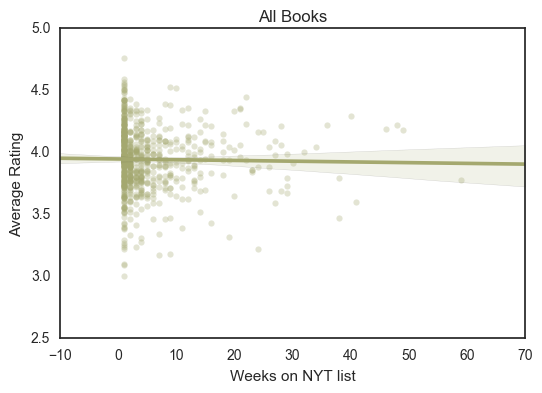

In [103]:
#get rid of the outlier on left
wks_vs_rating(books, 'All Books')

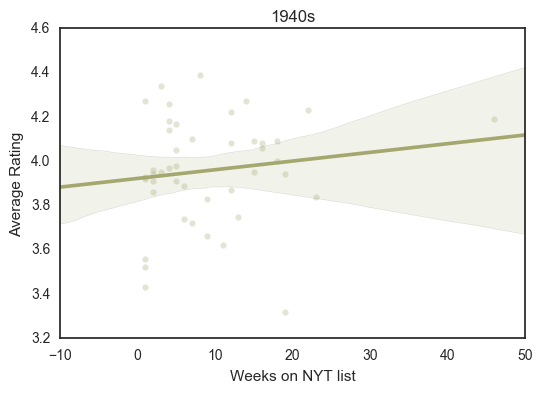

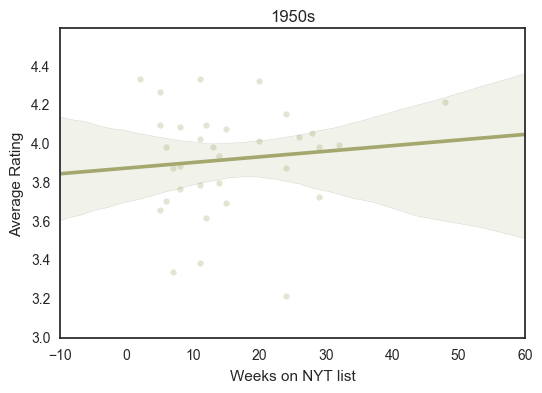

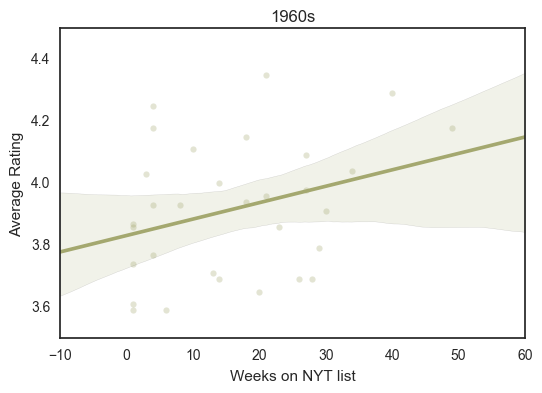

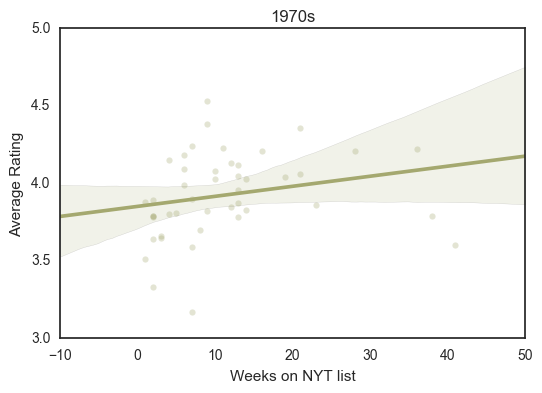

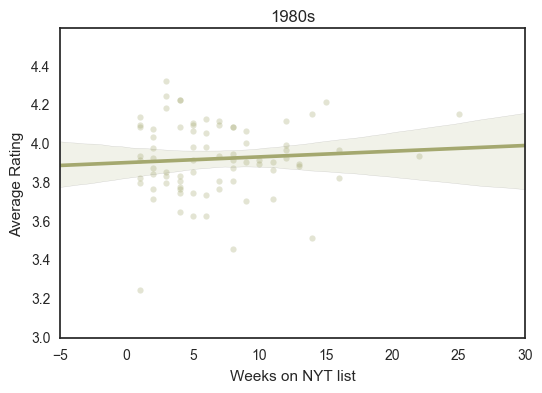

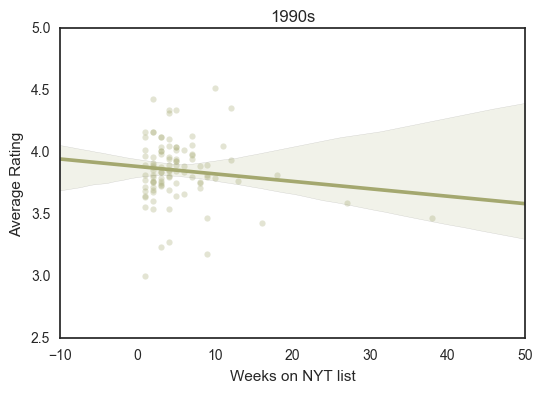

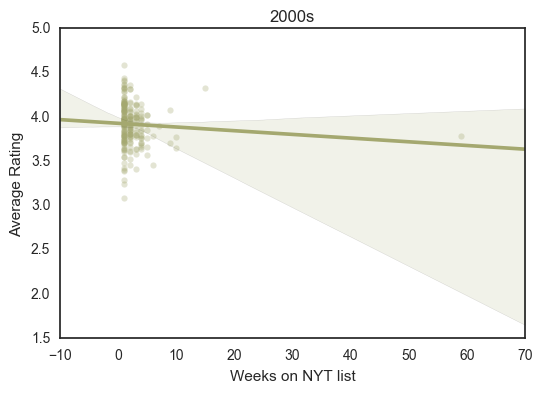

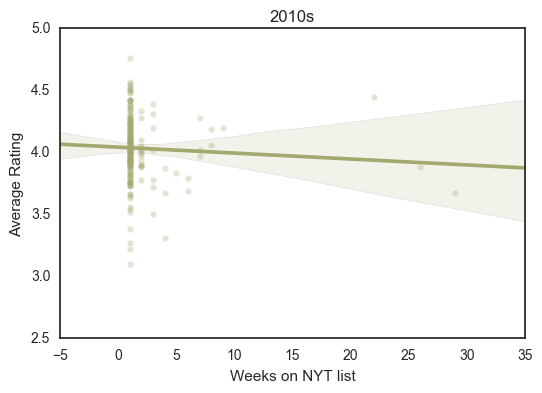

In [154]:
for decade in decades:
    #print type(decade)
    wks_vs_rating(books[books['decade'] == str(decade)], decade)

Hexplot of author rating vs book rating

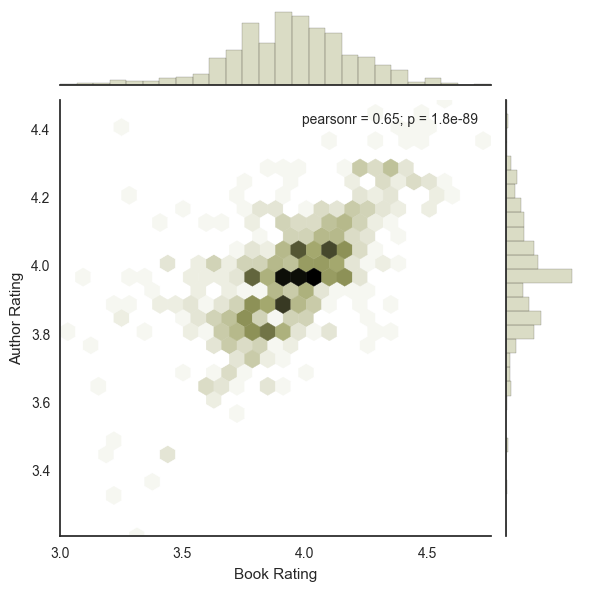

In [169]:
fig14 = sns.jointplot(x='b_avg_rating',
                      y='a_avg_rating',
                      data=books,
                      kind='hex',
                      color='#a4a86f');
fig14.set_axis_labels(xlabel='Book Rating', ylabel='Author Rating');

Barplot of ratings distributions (how many 5 ratings, 4 ratings, etc)

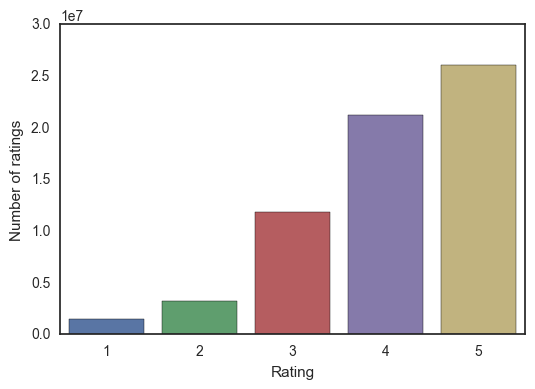

In [42]:
ratings = books[['b_rating_5_count', 'b_rating_4_count', 'b_rating_3_count', 'b_rating_2_count', 'b_rating_1_count']]
ratings = ratings.sum()
fig15 = sns.barplot(x=['5', '4', '3', '2', '1'], y=ratings)
fig15.set(xlabel='Rating', ylabel='Number of ratings');

Pairplots of book's average rating and book's characteristics

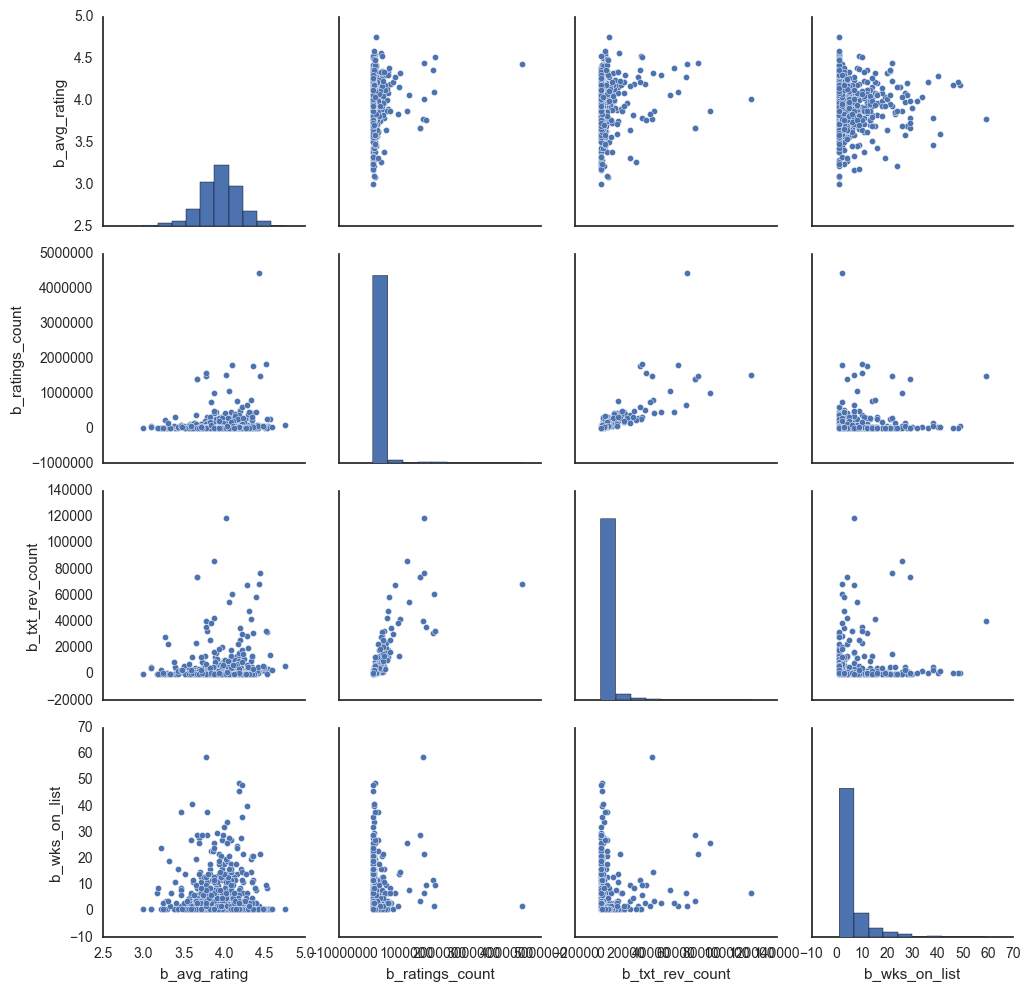

In [43]:
sns.pairplot(books[['b_avg_rating', 'b_ratings_count', 'b_txt_rev_count', 'b_wks_on_list']]);

Pairplots of book's average rating and author's characteristics

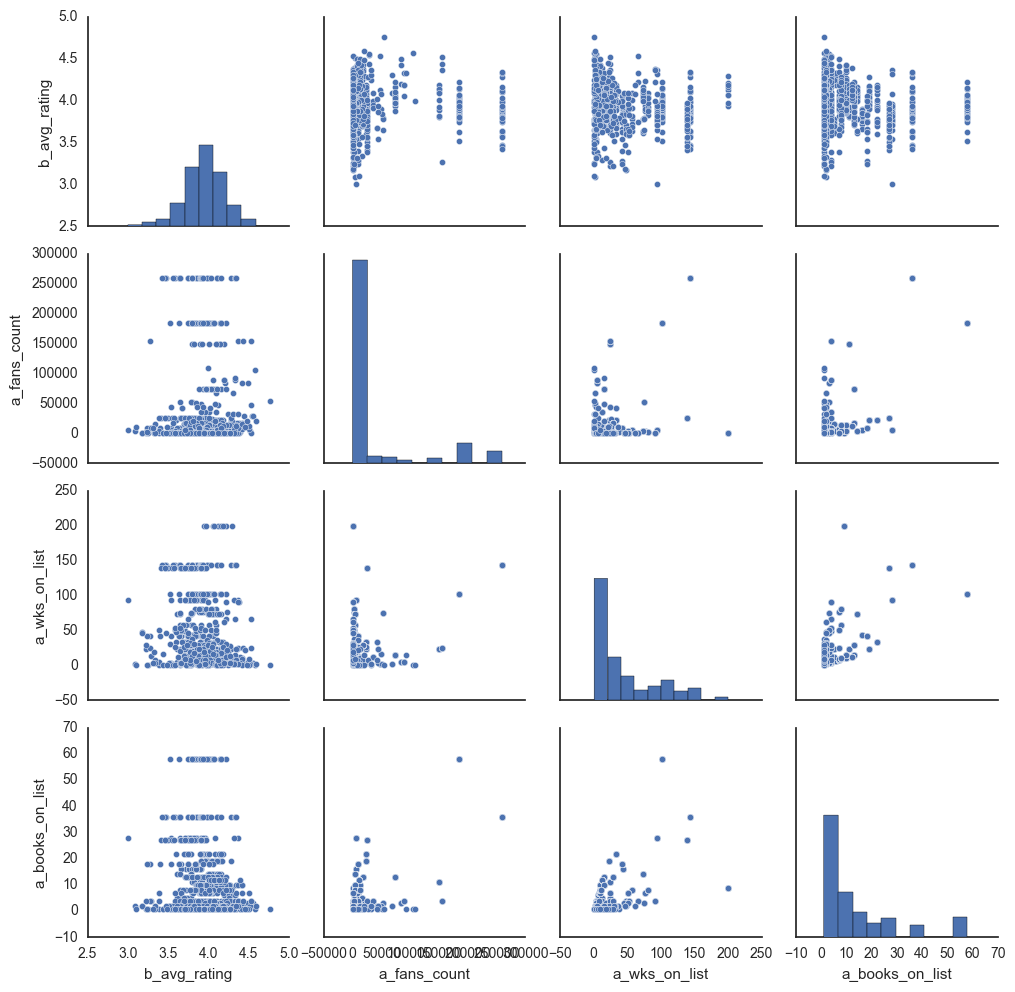

In [44]:
sns.pairplot(books[['b_avg_rating', 'a_fans_count', 'a_wks_on_list', 'a_books_on_list']]);

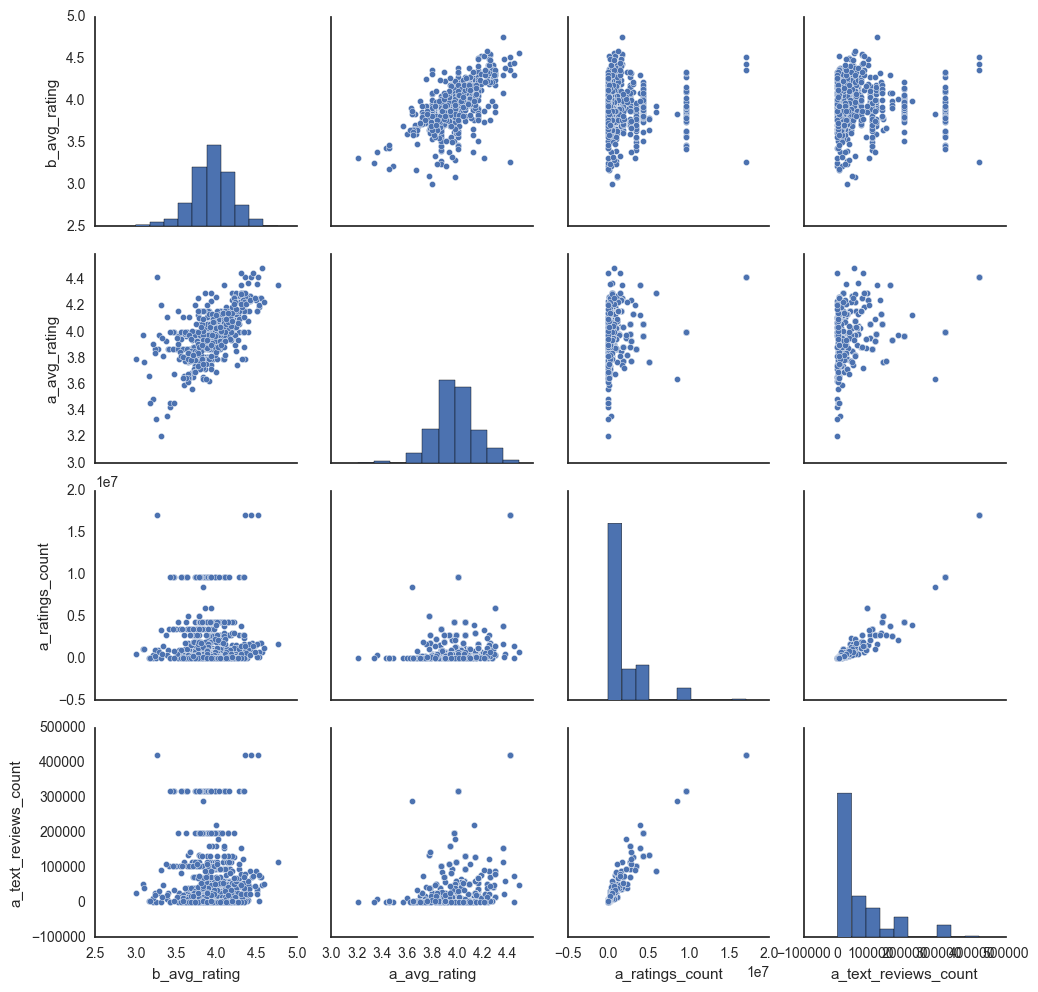

In [45]:
sns.pairplot(books[['b_avg_rating', 'a_avg_rating', 'a_ratings_count', 'a_text_reviews_count']]);

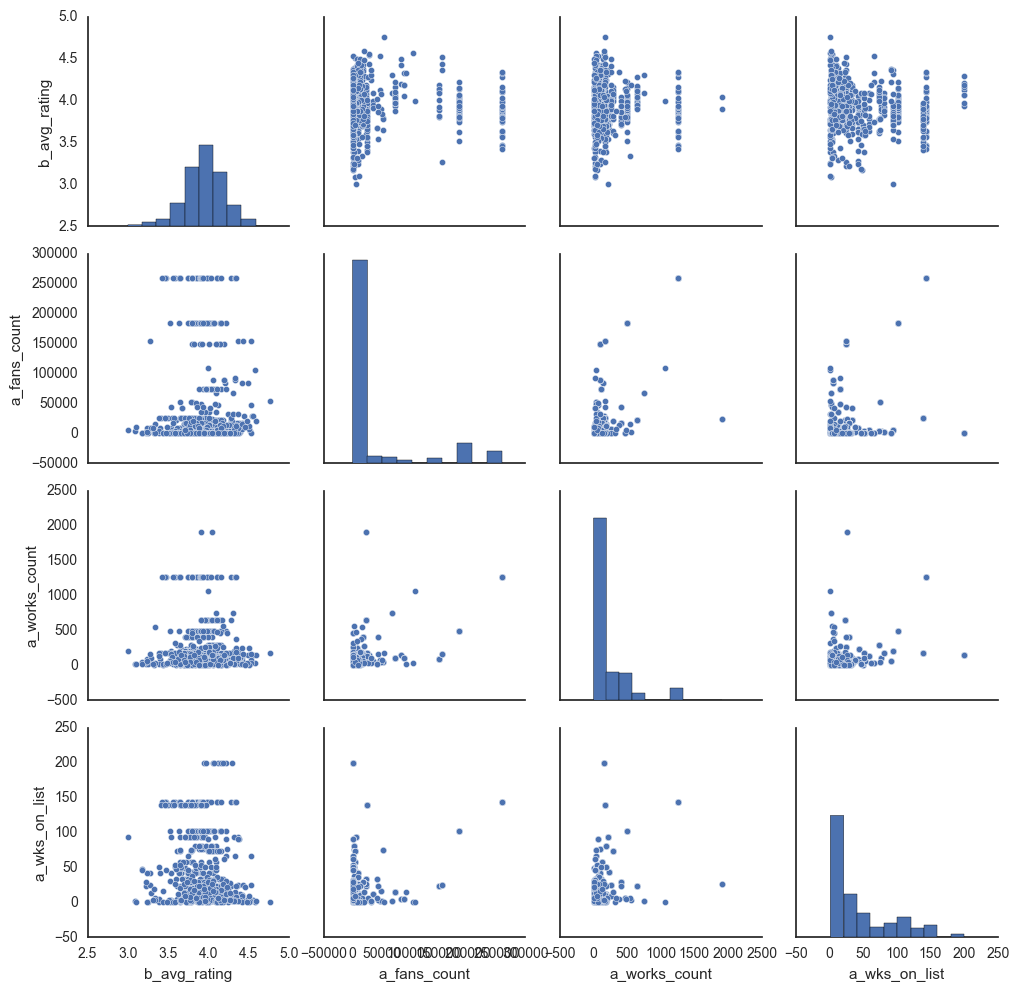

In [46]:
sns.pairplot(books[['b_avg_rating', 'a_fans_count', 'a_works_count', 'a_wks_on_list']]);